# ComputerVision2024 Term Project Demo

## Setup

In [1]:
import os
import json
import random

import cv2
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torchvision
import torchvision.transforms.v2 as T

import matplotlib.pyplot as plt

from data import AidaDataset
from tokenizers import LaTeXTokenizer
from transforms import FixedAspectResize, RandomSpots, Binarization
from models import LaTeXOCRModel, LitLaTeXOCRModel
from train import build_ocr_model

In [2]:
import mlflow

MLFLOW_TRACKING_URI = "http://140.113.240.120:5000"
EXPERIMENT_NAME = "CV2024 Term Project"

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [3]:
DATA_DIR = "data/cleaned_aida"

SEED = 101
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

INPUT_SIZE = 512
BATCH_SIZE = 8
LR = 2e-4
MILESTONES = [5,10,15,20]
GAMMA = 0.5

In [4]:
def _collate_fn(batch):
    inputs, targets = zip(*batch)
    inputs = torch.stack(inputs)
    targets = pad_sequence(targets, padding_value=tokenizer.pad_token_id, batch_first=True)

    return inputs, targets

## Load Dataset

In [5]:
tokenizer = LaTeXTokenizer.load_from(os.path.join(DATA_DIR, "vocab.json"))
test_transform = T.Compose([
    T.ToImage(),
    FixedAspectResize(512),
    T.ToDtype(torch.float32)
])
test_set = AidaDataset(DATA_DIR, tokenizer, mode="test", transform=test_transform)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, collate_fn=_collate_fn, num_workers=4, pin_memory=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

## Load Model

In [6]:
# load trained model
# ckpt_path = "mlflow-artifacts:/750741557423109817/84deaa43aa544aed9f466060a82c1c8a/artifacts/model/checkpoints/epoch=19-step=20000/epoch=19-step=20000.ckpt"
# ckpt = mlflow.pytorch.load_state_dict(ckpt_path)

model = build_ocr_model(tokenizer)
lit_model = LitLaTeXOCRModel(model, lr=LR, weight_decay=0.0001, milestones=MILESTONES, gamma=GAMMA)
ckpt = torch.load("checkpoints/epoch=19-step=20000.ckpt")
lit_model.load_state_dict(ckpt['state_dict'])
lit_model = lit_model.to(DEVICE)

## Aida

### Preview

In [7]:
with open("data/cleaned_aida/train_test_split.json") as f:
    data_split_conf = json.load(f)

sample_ids = data_split_conf['train_ids']

706edeff-f0ff-4de0-9a97-e98b90717bc8


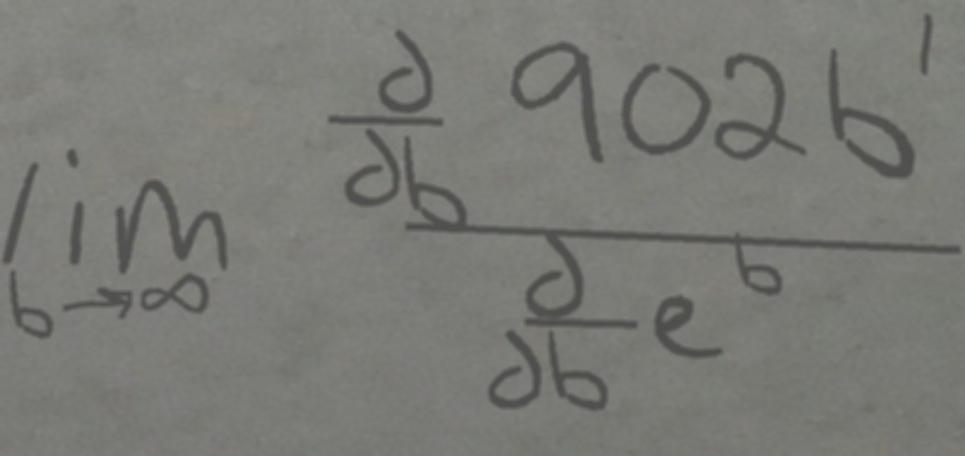

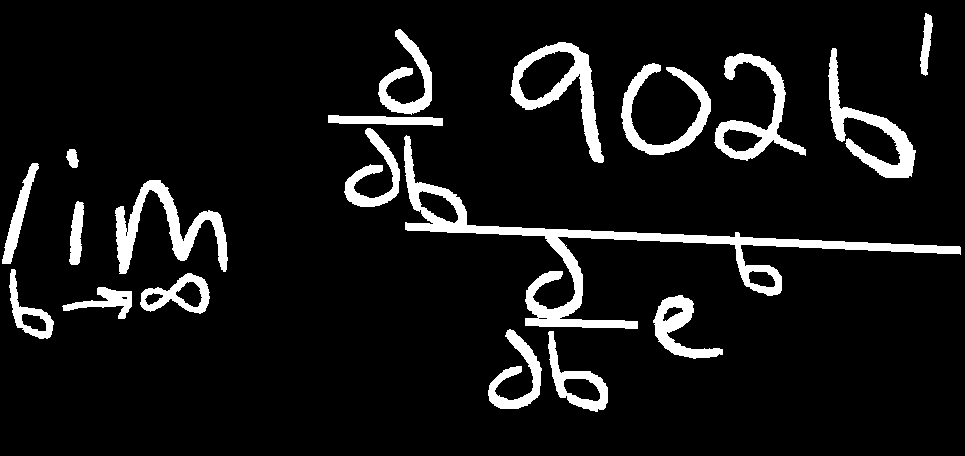

In [8]:
demo_id = random.choice(sample_ids)
demo_aida = Image.open(f"data/cleaned_aida/{demo_id}/raw_image.jpg")  # (H, W, C)
demo_aida_bin = Image.open(f"data/cleaned_aida/{demo_id}/masked_image.png")

print(demo_id)
display(demo_aida)
display(demo_aida_bin)

In [9]:
transform = T.Compose([
    T.ToImage(),
    FixedAspectResize(512),
    T.RandomRotation(degrees=10),
    T.ToDtype(torch.float32),
])

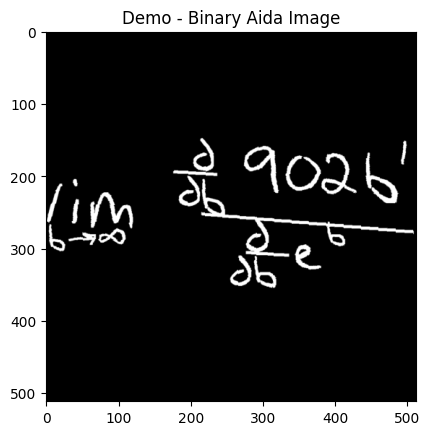

In [10]:
new_demo_aida_bin = transform(demo_aida_bin)

plt.imshow(new_demo_aida_bin.squeeze(0), cmap='gray')
plt.title("Demo - Binary Aida Image")
plt.show()

### Generate

In [11]:
latex_id_seq = lit_model.model.predict(new_demo_aida_bin.unsqueeze(0).to(DEVICE))[0].tolist()
latex_seq = tokenizer.decode(latex_id_seq, remove_special_tokens=True)
latex_seq

['\\lim',
 '_',
 '{',
 'b',
 '\\to',
 '\\infty',
 '}',
 '\\frac',
 '{',
 '\\frac',
 '{',
 'd',
 '}',
 '{',
 'd',
 'b',
 '}',
 '9',
 '0',
 '2',
 'b',
 '^',
 '{',
 '1',
 '}',
 '}',
 '{',
 '\\frac',
 '{',
 'd',
 '}',
 '{',
 'd',
 'b',
 '}',
 'e',
 '^',
 '{',
 'b',
 '}',
 '}']

In [14]:
latex = ''.join(latex_seq)
print(latex)

\lim_{b\to\infty}\frac{\frac{d}{db}902b^{1}}{\frac{d}{db}e^{b}}


## Blackboards

### Preview

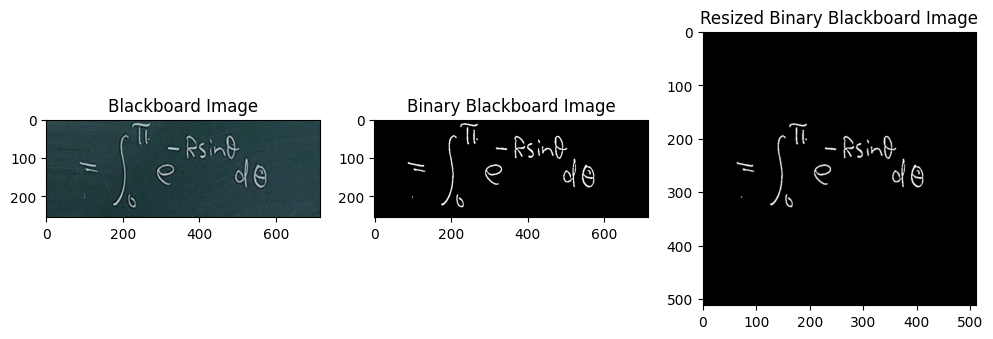

In [32]:
demo_bb_name = "crop_7"
demo_bb = cv2.imread(f"data/demo/blackboards/{demo_bb_name}.jpg")  # (H, W, C)

binarizer = Binarization()
demo_bb_bin = binarizer(demo_bb)

demo_bb_bin = Image.fromarray(demo_bb_bin)
resizer = FixedAspectResize(512)
demo_bb_resized = resizer(demo_bb_bin)
demo_bb_resized = np.array(demo_bb_resized)


fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(cv2.cvtColor(demo_bb, cv2.COLOR_BGR2RGB))
axes[0].set_title("Blackboard Image")
axes[1].imshow(demo_bb_bin, cmap='gray')
axes[1].set_title("Binary Blackboard Image")
axes[2].imshow(demo_bb_resized, cmap='gray')
axes[2].set_title("Resized Binary Blackboard Image")
plt.show()

### Generate

In [33]:
bb_transform = T.Compose([
    Binarization(),
    T.ToImage(),
    FixedAspectResize(512),
    T.ToDtype(torch.float32),
])

In [34]:
demo_bb_pt = bb_transform(demo_bb)
latex_id_seq = lit_model.model.predict(demo_bb_pt.unsqueeze(0).to(DEVICE))[0].tolist()
latex_seq = tokenizer.decode(latex_id_seq, remove_special_tokens=True)
latex = ''.join(latex_seq)
print(latex)

-\lim_{v\to-\infty}e^{7v}+3}
